In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 140

# Loading data

In [2]:
X_train_full = pd.read_csv('data\\training_set_features.csv', index_col = 'respondent_id')
y_train_full = pd.read_csv('data\\training_set_labels.csv', index_col = 'respondent_id')

In [3]:
X_test = pd.read_csv('data\\test_set_features.csv', index_col = 'respondent_id')

# Data First Impressions

In [4]:
X_train_full.shape

(26707, 35)

In [5]:
X_train_full.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [6]:
y_train_full.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [7]:
X_train_full.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [8]:
X_train_full['h1n1_concern'].dtype

dtype('float64')

In [9]:
float_cols = [col for col in X_train_full.columns if X_train_full[col].dtype == 'float64']

In [10]:
X_train_full[float_cols[:len(float_cols)//2]].describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [11]:
X_train_full[float_cols[len(float_cols)//2:]].describe()

,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


* We can see that most columns are binary (either 0 or 1) - this can be seen from the quartiles of the data.
* We can also immediately see that some columns have missing values - count < data.shape[0].

# Data Cleaning

Lets see which columns have missing values:

In [12]:
missing_values_df = pd.DataFrame({'Missing Absolute': X_train_full.isna().sum(),
              'Missing Percentage': np.round(X_train_full.isna().sum()/X_train_full.shape[0] * 100, 2)})
missing_values_df

,Missing Absolute,Missing Percentage
h1n1_concern,92,0.34
h1n1_knowledge,116,0.43
behavioral_antiviral_meds,71,0.27
behavioral_avoidance,208,0.78
behavioral_face_mask,19,0.07
behavioral_wash_hands,42,0.16
behavioral_large_gatherings,87,0.33
behavioral_outside_home,82,0.31
behavioral_touch_face,128,0.48
doctor_recc_h1n1,2160,8.09


Lets look more closely to the features with more than 10% missing values:

In [13]:
missing_values_df[missing_values_df['Missing Percentage'] > 10]

,Missing Absolute,Missing Percentage
health_insurance,12274,45.96
income_poverty,4423,16.56
employment_industry,13330,49.91
employment_occupation,13470,50.44


These columns have such a high percentage of missing values that I might consider just dropping them out of the classification.
However, I believe these columns could have a big impact on the success of the algorithm because:

* *health_insurance* - health insurance could cover the vacine costs and also the treatment so it influences the person's decision to take the shot;
* *income_poverty* - lower income people probably tend to not get the vaccine as often as higher income people;
* *employment_industry/occupation* - a person working in the health sector is probably more likely to get the shots than someone from other industries.

Thus, I believe we should make an effort to fill the missing values in these columns.

For the *income_poverty* feature, the possible values are:

In [14]:
X_train_full['income_poverty'].value_counts()

<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

Which we can simplify in terms of income as [*Low*, *Medium*, *High*]:

In [15]:
# X_train_full['income_poverty'].replace('Below Poverty', 'Low', inplace = True)
# X_train_full['income_poverty'].replace('<= $75,000, Above Poverty', 'Medium', inplace = True)
# X_train_full['income_poverty'].replace('> $75,000', 'High', inplace = True)

We should design a function to do make this simpification more general so that we can later apply it to the test dataset:

In [16]:
def simplify_col_names(df):
    df['income_poverty'].replace('Below Poverty', 'Low', inplace = True)
    df['income_poverty'].replace('<= $75,000, Above Poverty', 'Medium', inplace = True)
    df['income_poverty'].replace('> $75,000', 'High', inplace = True)
    
    df['age_group'].replace('65+ Years', '65+', inplace = True)
    df['age_group'].replace('55 - 64 Years', '55+', inplace = True)
    df['age_group'].replace('45 - 54 Years', '45+', inplace = True)
    df['age_group'].replace('35 - 44 Years', '35+', inplace = True)
    df['age_group'].replace('18 - 34 Years', '18+', inplace = True)
    
    df['education'].replace('College Graduate', 'Very High', inplace = True)
    df['education'].replace('Some College', 'High', inplace = True)
    df['education'].replace('12 Years', 'Medium', inplace = True)
    df['education'].replace('< 12 Years', 'Low', inplace = True)

In [17]:
simplify_col_names(X_train_full)

Now, from our EDA, we can see that income has a relation with taking the vaccines so we should try to *OrdinalEncode* this column:

In [18]:
from sklearn.impute import SimpleImputer

imputer_most_frequent = SimpleImputer(strategy='most_frequent')

In [19]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

income_pipe = Pipeline(steps=[('impute', imputer_most_frequent),
                              ('encode', OrdinalEncoder(categories=[np.array(['Low', 'Medium', 'High'])]))
                             ])

missing_values_df.drop('income_poverty', axis = 0, inplace = True)

ordinal_cols = ['income_poverty']

We will now do the same for the *education* and *age_group* columns:

In [20]:
education_pipe = Pipeline(steps=[('impute', imputer_most_frequent),
                                 ('encode', OrdinalEncoder(categories=[np.array(['Low', 'Medium', 'High', 'Very High'])]))
                                ])

age_pipe = Pipeline(steps=[('impute', imputer_most_frequent),
                           ('encode', OrdinalEncoder(categories=[np.array(['18+', '35+', '45+', '55+', '65+'])]))
                          ])

ordinal_cols.extend(['education', 'age_group'])

Regarding, *health_insurance* and *employment_industry/occupation*, taking into account that almost half of the data is missing, I am going to drop these columns for now, instead of making possibly biased assumptions about the data.

In [21]:
cols_drop = ['health_insurance', 'employment_industry', 'employment_occupation']
missing_values_df.drop(cols_drop, axis = 0, inplace = True)

Now, we can look into two other columns with missing values (> 8% missing) - *doctor_recc_h1n1* and *doctor_recc_seasonal*:

In [22]:
missing_values_df[missing_values_df['Missing Percentage'] > 8]

,Missing Absolute,Missing Percentage
doctor_recc_h1n1,2160,8.09
doctor_recc_seasonal,2160,8.09


In [23]:
pd.DataFrame({'Recc H1N1': X_train_full['doctor_recc_h1n1'].value_counts(),
              'Recc SEAS': X_train_full['doctor_recc_seasonal'].value_counts()})

,Recc H1N1,Recc SEAS
0.0,19139,16453
1.0,5408,8094


Since doctors seem to not recommend the vacines about 2-3 times as often as they recommend it, we can assume that the missing values represent times where the doctor did not recommend the shots. So:

In [24]:
doctor_recc_list = ['doctor_recc_h1n1', 'doctor_recc_seasonal']

cols_most_frequent = []
cols_most_frequent.extend(doctor_recc_list)

missing_values_df.drop(doctor_recc_list, axis = 0, inplace = True)

For the remaining columns, we can also impute them with the *most frequent* value since there are <8% of missing values and the values are mostly categorical so we dont want to impute with the mean. Thus: 

In [25]:
cols_most_frequent.extend(list(missing_values_df[missing_values_df > 0].index))

In [26]:
categorical_cols = [col for col in X_train_full.columns if X_train_full[col].dtype == 'object' 
                    and col not in cols_drop and col not in ordinal_cols]

In [27]:
categorical_cols

['race',
 'sex',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

In [28]:
from sklearn.preprocessing import OneHotEncoder

cat_preprocessor = Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                             ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False))
                            ])

This preprocessing can be made convenient using *scikit learn* and a *ColumnTransformer*:cols_most_frequent.extend(cols_drop)

In [29]:
numerical_cols = [col for col in X_train_full.columns if col not in categorical_cols
                  and col not in cols_drop and col not in ordinal_cols]

# Feature Engineering

Using the conclusions of our EDA, we want to engineer the following features:
* *general_behavior*
* *general_effective*
* *general_risk*
* *general_reccomendation*

In [30]:
def engineer_features(df):
    behavioral_cols = ['behavioral_antiviral_meds',
                   'behavioral_avoidance',
                   'behavioral_face_mask',
                   'behavioral_wash_hands',
                   'behavioral_large_gatherings',
                   'behavioral_outside_home',
                   'behavioral_touch_face']

    #df['general_behavior'] = pd.Series(np.zeros(df.shape[0]), index = df.index)
    #for b_col in behavioral_cols:
    #   df['general_behavior'] += df[b_col]
        
    df['general_effective'] = df['opinion_h1n1_vacc_effective'] + df['opinion_seas_vacc_effective']

    df['general_risk'] = df['opinion_h1n1_risk'] + df['opinion_seas_risk']
    
    df['general_eff_risk'] = df['general_effective'] + df['general_risk']
    
    df['general_reccomendation'] = df['doctor_recc_h1n1'] + df['doctor_recc_seasonal']

In [31]:
engineer_features(X_train_full)

In [32]:
engineered_features = ['general_effective',
                       'general_risk',
                       'general_eff_risk',
                       'general_reccomendation']

numerical_cols.extend(engineered_features)

In [33]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([('numerical_cols', imputer_most_frequent, numerical_cols),
                                  ('categorical_cols', cat_preprocessor, categorical_cols),
                                  ('income', income_pipe, ['income_poverty']),
                                  ('education', education_pipe, ['education']),
                                  ('age', age_pipe, ['age_group']),
                                  ('drop', 'drop', cols_drop)])

# Benchmark Model

To begin with, I want to build a simple model which makes some predictions just to benchmark it and to make my first submission to the competion.

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full,
                                                      train_size=0.8,
                                                      random_state=42,
                                                      shuffle=True)

In [35]:
from xgboost import XGBClassifier

XGB_params = {}

XGB_class = XGBClassifier(**XGB_params, objective='reg:logistic', random_state=42, use_label_encoder=False)

In [51]:
from lightgbm import LGBMClassifier

LGBM_class = LGBMClassifier()

In [52]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

XGB_multi_class = MultiOutputClassifier(estimator=LGBM_class)

In [53]:
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([('preprocessor', preprocessor),
                          ('estimator', XGB_multi_class)])

In [54]:
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_cols',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1...
                                                          

In [55]:
y_pred = full_pipeline.predict_proba(X_valid)
y_pred = pd.DataFrame({'h1n1_vaccine': y_pred[0][:, 1],
                       'seasonal_vaccine': y_pred[1][:, 1]}, index = X_valid.index)

In [56]:
from sklearn.metrics import roc_auc_score, roc_curve

In [57]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

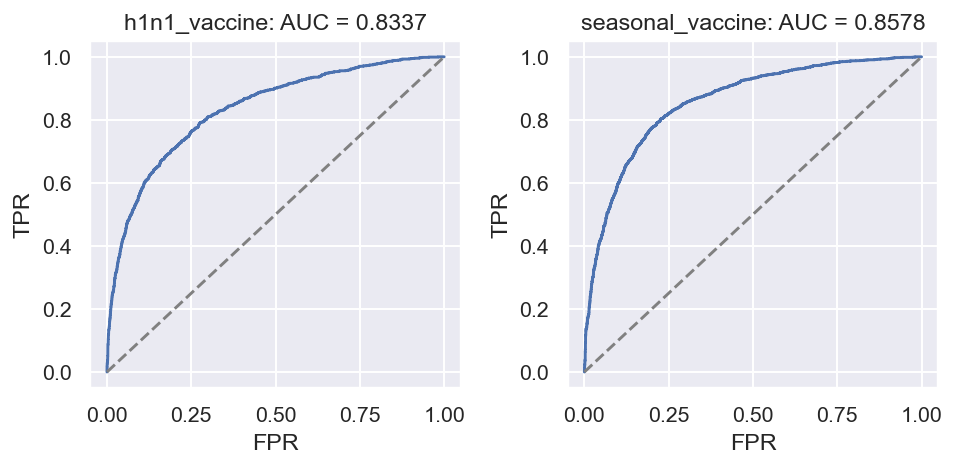

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_valid['h1n1_vaccine'], 
    y_pred['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_valid['seasonal_vaccine'], 
    y_pred['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [59]:
score = roc_auc_score(y_valid, y_pred)
print(f'ROC validation (mean) score: {score}')

ROC validation (mean) score: 0.8457572963516458


# Making predictions

In [44]:
simplify_col_names(X_test)

In [45]:
engineer_features(X_test)

In [46]:
predictions = full_pipeline.predict_proba(X_test)
predictions = pd.DataFrame({'respondent_id': X_test.index,
                            'h1n1_vaccine': predictions[0][:, 1],
                            'seasonal_vaccine': predictions[1][:, 1]
                           })

In [47]:
predictions

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.052684,0.047693
1,26708,0.026313,0.010919
2,26709,0.612146,0.903345
3,26710,0.556689,0.897287
4,26711,0.231126,0.256873
...,...,...,...
26703,53410,0.209051,0.526286
26704,53411,0.133465,0.130562
26705,53412,0.105754,0.210085
26706,53413,0.003306,0.234178


In [48]:
predictions.to_csv('predictions.csv', index = False)